In [1]:
#Import Packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rioxarray as rx

In [2]:
# geodataframe
balt_bg = gpd.read_file("model_inputs/bg_baltimore.csv", 
                        GEOM_POSSIBLE_NAMES="geometry",
                        KEEP_GEOM_COLUMNS="NO")

balt_bg = balt_bg.set_crs('epsg:3857')
bg_visual = balt_bg.to_crs('epsg:4269')


<Axes: >

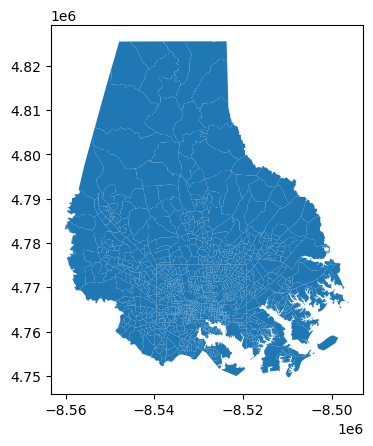

In [3]:
#visualize geodataframe
balt_bg.plot()

In [29]:
#open tif file
raster = rx.open_rasterio("flood_inputs/FastFlood/Base/Surge-BaltimoreBase-10m_27.tif")

In [30]:
#raster = raster.rio.clip_box(-77, 39.15, -76.3, 39.9)
raster.rio.crs

CRS.from_epsg(4269)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

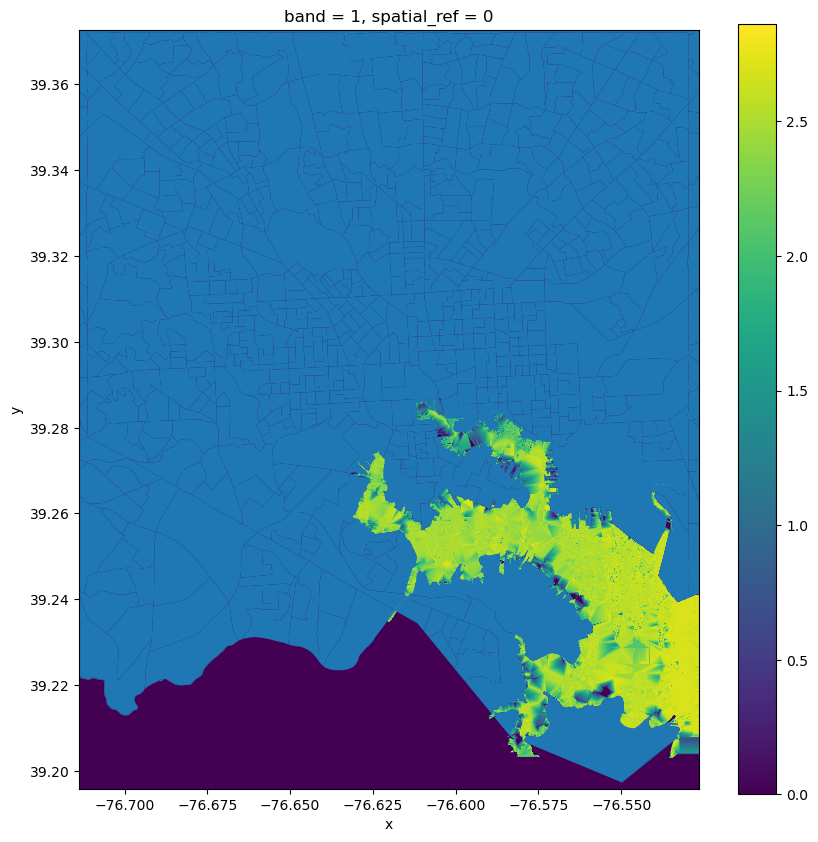

In [33]:

f, ax = plt.subplots(1, figsize=(10, 10))
raster.plot(ax=ax)
bg_visual.plot(ax=ax)

In [34]:
#get first band of raster
band = raster[0]
x, y, extent = band.x.values, band.y.values, band.values
x, y = np.meshgrid(x, y)
x, y, extent = x.flatten(), y.flatten(), extent.flatten()

In [35]:
#Convert to point geometries 
centroids = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(x, y, crs=band.rio.crs))
centroids['extent'] = extent

In [36]:
#join centroid geometries with block group geometries
bg_flood_area = gpd.sjoin(bg_visual,centroids)



In [42]:
#determine whether max flood depth occurrence within each block group
bg_flood_max = bg_flood_area[["GISJOIN","extent"]].groupby('GISJOIN').max()
#bg_flood_max = bg_flood_max.round({'extent':0})

#Rejoin block group geometries
balt_flood = bg_visual[["GISJOIN","geometry"]].merge(bg_flood_max, on='GISJOIN')

<Axes: >

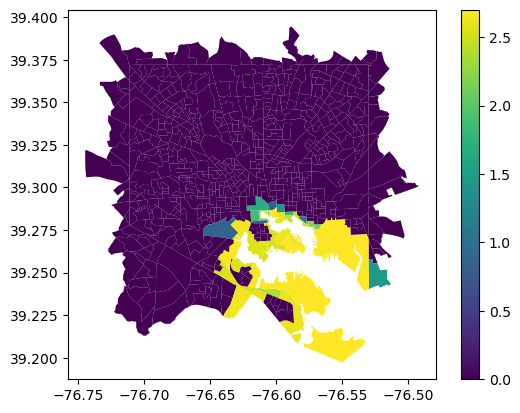

In [43]:
balt_flood.plot(column = 'extent',legend=True)

In [44]:
balt_flood

,GISJOIN,geometry,extent
0,G24000307301003,"POLYGON ((-76.53287 39.20775, -76.54602 39.199...",2.700000
1,G24000307501012,"MULTIPOLYGON (((-76.60474 39.22794, -76.60476 ...",0.000000
2,G24000307501021,"MULTIPOLYGON (((-76.61476 39.23577, -76.61529 ...",2.631417
3,G24000307502012,"MULTIPOLYGON (((-76.63468 39.22342, -76.63472 ...",0.000000
4,G24000307503001,"MULTIPOLYGON (((-76.64141 39.22556, -76.64150 ...",0.000000
...,...,...,...
741,G24051002804042,"POLYGON ((-76.68893 39.28821, -76.68929 39.288...",0.000000
742,G24051002805001,"POLYGON ((-76.59441 39.29838, -76.59437 39.297...",0.000000
743,G24051002805002,"POLYGON ((-76.60299 39.29480, -76.60294 39.293...",0.000000
744,G24051002805003,"POLYGON ((-76.59984 39.29492, -76.60046 39.294...",0.000000


In [41]:
raster

<xarray.DataArray (band: 1, y: 5732, x: 6066)>
[34770312 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -76.71 -76.71 -76.71 ... -76.53 -76.53 -76.53
  * y            (y) float64 39.37 39.37 39.37 39.37 ... 39.2 39.2 39.2 39.2
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0